In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Files to load
fns = ["train/X_train.txt", "train/y_train.txt", "test/X_test.txt", "test/y_test.txt"]

# Read files
X_train, X_test = pd.read_fwf(fns[0], header=None), pd.read_fwf(fns[2], header=None)
y_train, y_test = pd.read_fwf(fns[1], header=None), pd.read_fwf(fns[3], header=None)

# Merge sets since we're not doing supervised learning with need to verification in the usual sense
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [3]:
# Display some data to verify it works
print(X.shape)
X.head()

(10299, 561)


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [4]:
y.head()

,0
0,5
1,5
2,5
3,5
4,5


In [5]:
# Get counts for each label
print(y[0].value_counts())

6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: 0, dtype: int64


In [6]:
# Min samples estimation
minpts = X.shape[1]

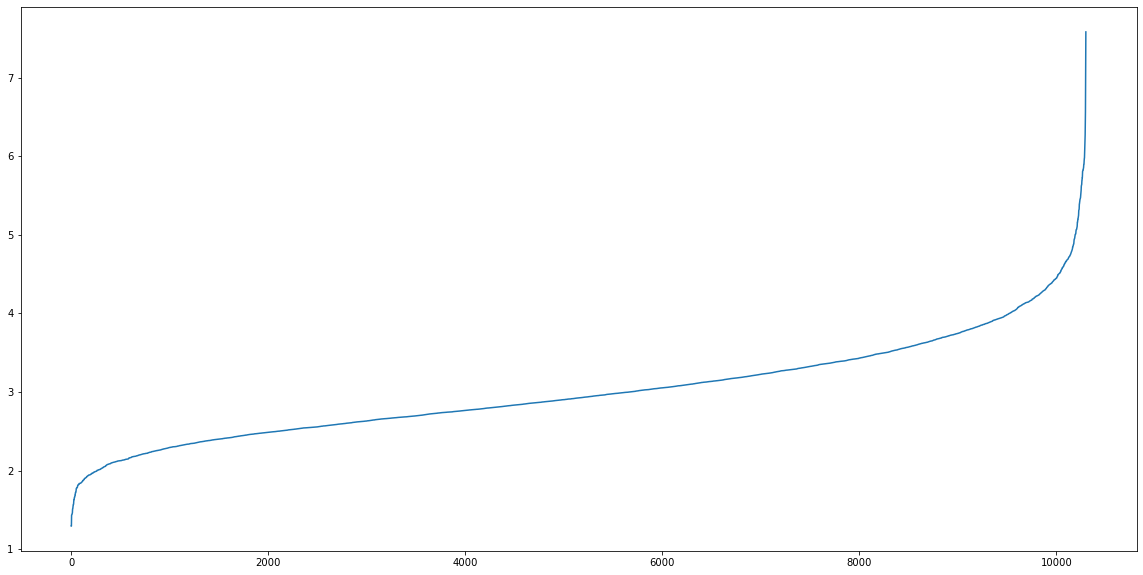

In [7]:
# Epsilon estimation
neighbors = NearestNeighbors(n_neighbors=minpts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

plt.figure(figsize=(20,10))
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
#plt.savefig("k-distances-1.png")
plt.show()

In [8]:
# Perform clustering
cluster = DBSCAN(eps=4.53, min_samples=minpts)
cluster.fit(X)
labels = cluster.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Estimated number of clusters: {}".format(n_clusters))
print("Number of noise points: {}".format(n_noise))

Estimated number of clusters: 2
Number of noise points: 4417


In [9]:
# Fit predict and get unique labels
labels = cluster.fit_predict(X)
unique = np.unique(labels)
b = int(len(unique))
print(unique)

[-1  0  1]


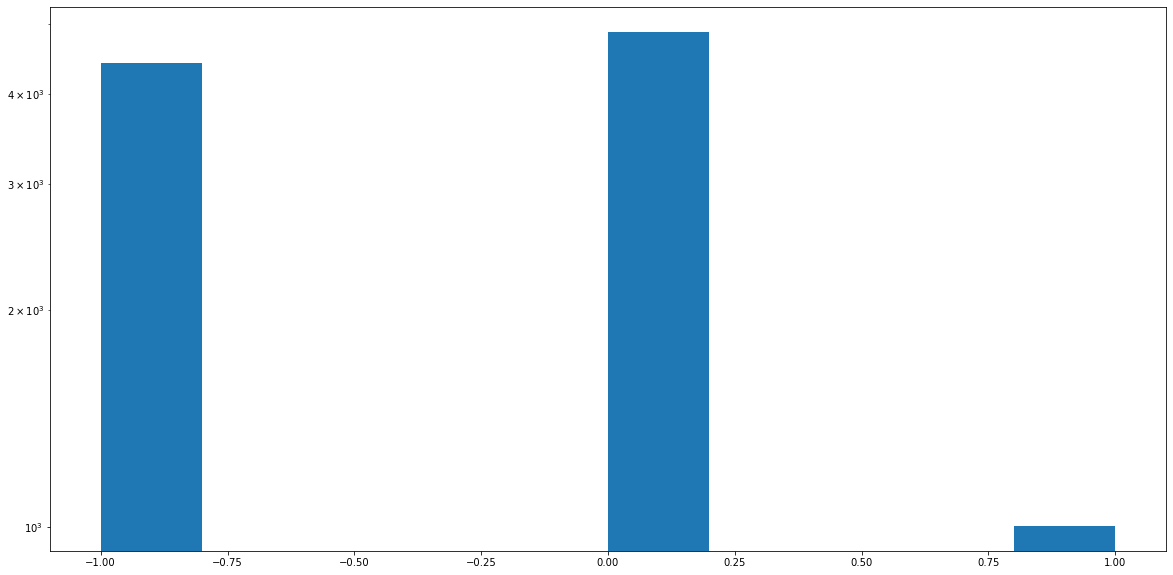

In [10]:
# Plot distribution of clustered labels. NOTE: logarithmic scale
plt.figure(figsize=(20,10))
plt.hist(labels)
plt.yscale("log")
#plt.savefig("cluster-distribution-1.png")
plt.show()

In [11]:
# Produce t-SNE embedding. NOTE: it may produce varying embeddings when run multiple times due to its stochastic methods
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.007s...
[t-SNE] Computed neighbors for 10299 samples in 2.280s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 1.351447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.123360
[t-SNE] KL

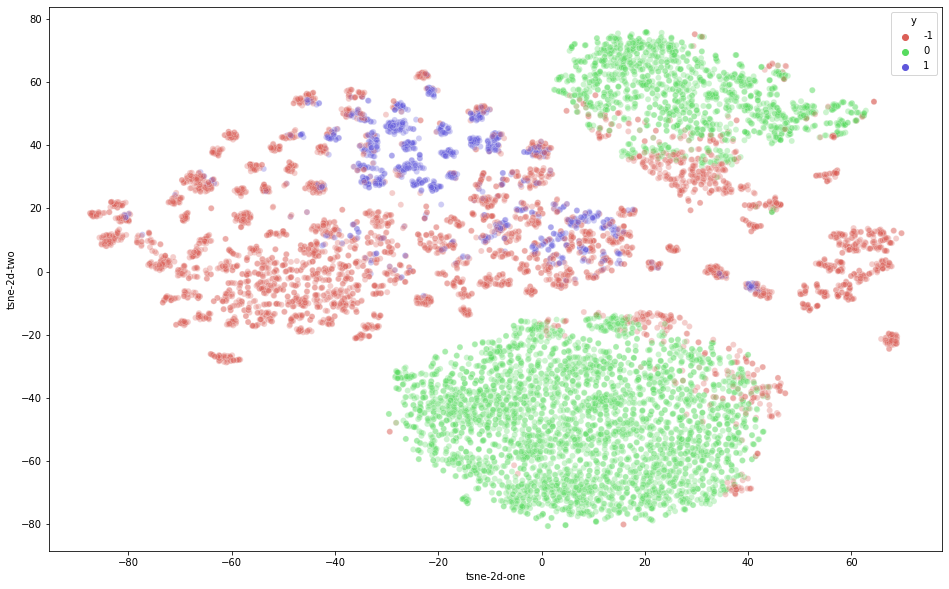

In [12]:
# Plot t-SNE embedding
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", 
    hue="y",
    palette=sns.color_palette("hls", b),
    data=df_subset,
    legend="full",
    alpha=0.3
)
#plt.savefig("cluster-results-1.png")
plt.show()

In [13]:
# Perform Principal component analysis
pca = PCA(n_components=25, svd_solver="full")
X_new = pca.fit_transform(X, y=y)

In [14]:
# Min samples estimation
minpts = X_new.shape[1]
print(minpts)

25


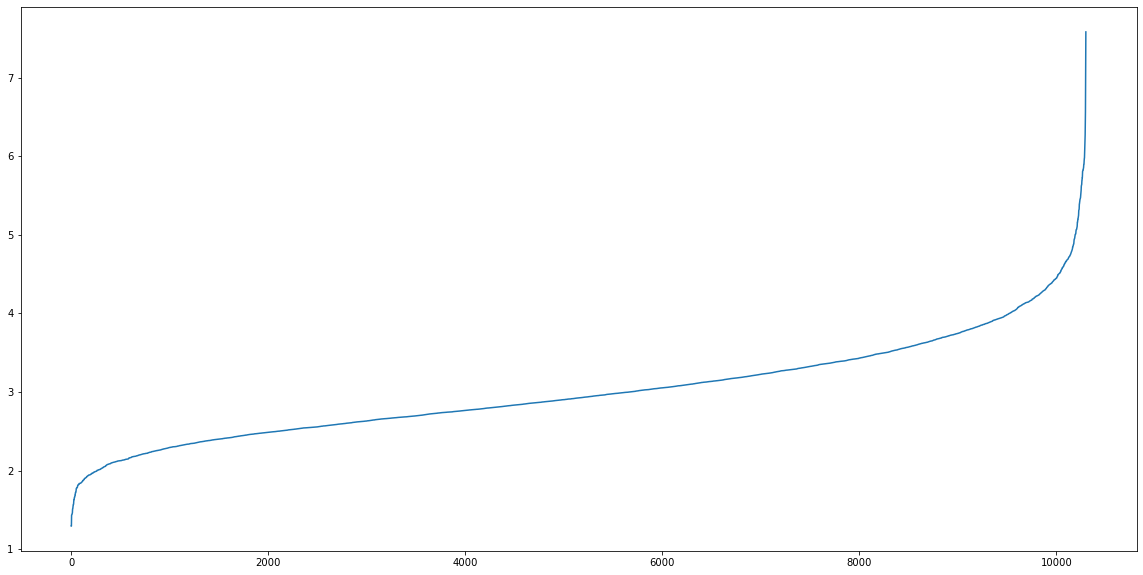

In [15]:
# Epsilon estimation
neighbors = NearestNeighbors(n_neighbors=minpts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(20,10))
plt.plot(distances)
#plt.savefig("k-distances-2.png")
plt.show()

In [24]:
# Perform clustering
cluster = DBSCAN(eps=4.175, min_samples=minpts)
cluster.fit(X)
labels = cluster.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Estimated number of clusters: {}".format(n_clusters))
print("Number of noise points: {}".format(n_noise))

Estimated number of clusters: 6
Number of noise points: 2163


In [17]:
# Fit predict and get unique labels
labels = cluster.fit_predict(X)
unique = np.unique(labels)
b = int(len(unique))
print(unique)

[-1  0  1  2  3  4  5]


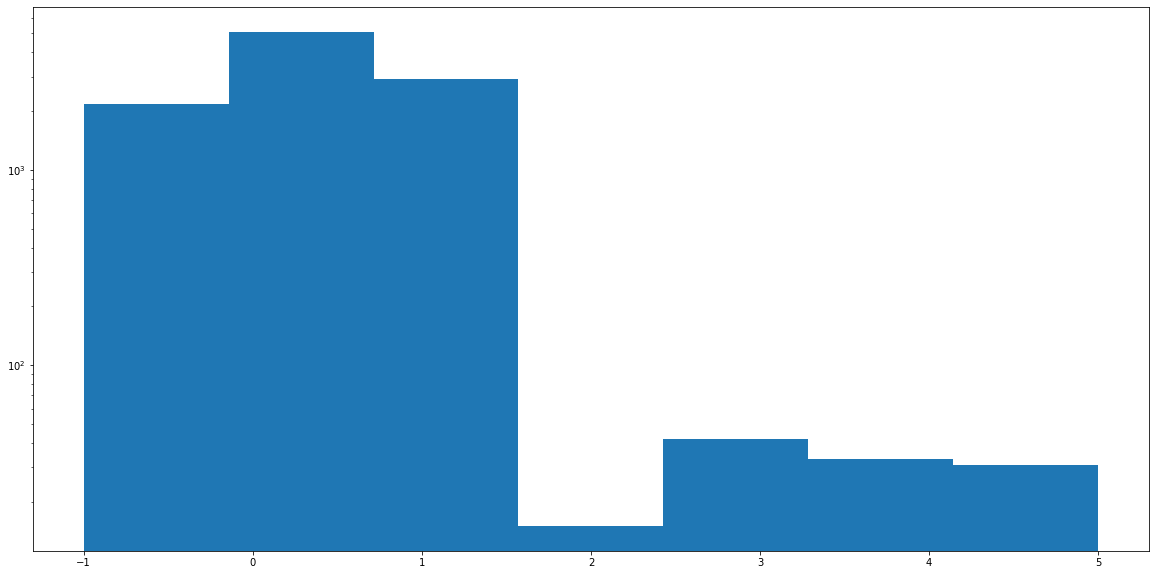

In [18]:
# Plot label distribution NOTE: logarithmic scale
plt.figure(figsize=(20,10))
plt.hist(labels, bins=b)
plt.yscale("log")
#plt.savefig("cluster-distribution-2.png")
plt.show()

In [19]:
# Produce t-SNE embedding. NOTE: it may produce varying embeddings when run multiple times due to its stochastic methods
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.007s...
[t-SNE] Computed neighbors for 10299 samples in 2.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 1.351447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.860733
[t-SNE] KL

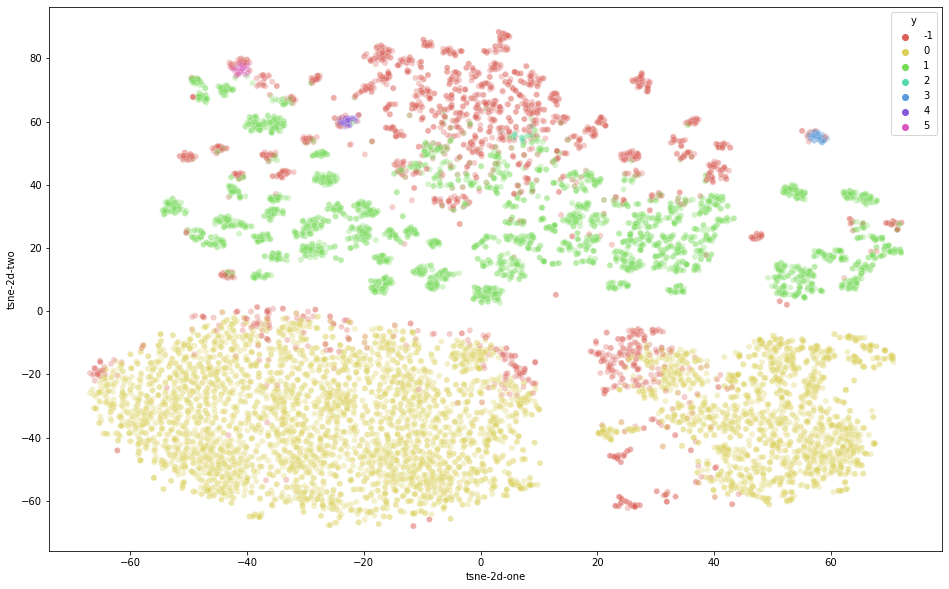

In [20]:
# Plot cluster results.
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", 
    hue="y",
    palette=sns.color_palette("hls", b),
    data=df_subset,
    legend="full",
    alpha=0.3
)
#plt.savefig("cluster-results-2.png")
plt.show()

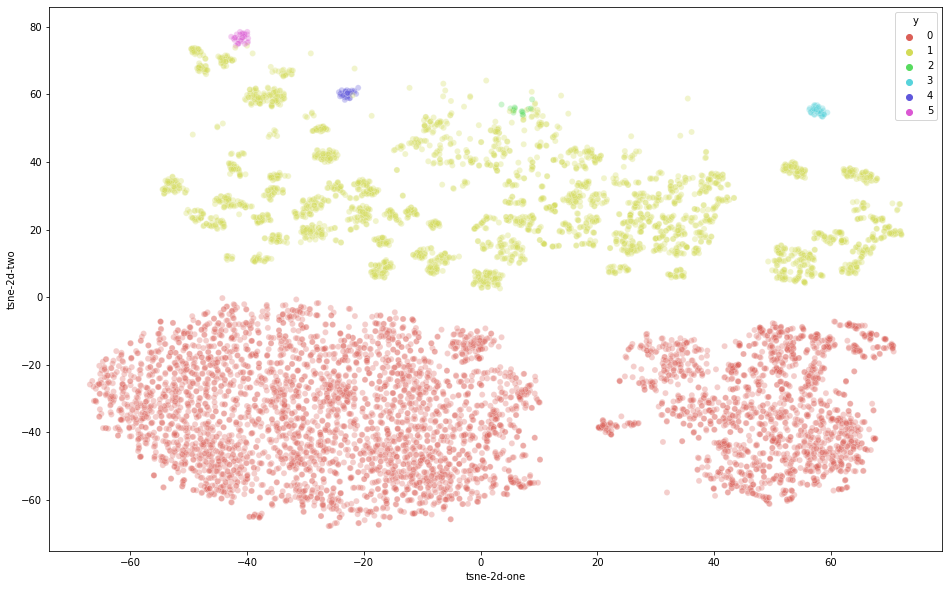

In [21]:
# Plot cluster results with noise removed
df_subset = df_subset[df_subset.y != -1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", 
    hue="y",
    palette=sns.color_palette("hls", b-1),
    data=df_subset,
    legend="full",
    alpha=0.3
)
#plt.savefig("cluster-results-2-filtered.png")
plt.show()